In [1]:
%matplotlib inline
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from proteus.visu import matrix as visu
from proteus.matrix import tseries as ts
import nibabel as nib
from nibabel.affines import apply_affine
import pandas as pd
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression
from nilearn.masking import compute_epi_mask

# Load data
we load the data depending on the source HC0040123, SZ0040142 and SZ0040084

In [2]:
subj_id='HC0040123'

In [3]:
# CRIUGM original pierre
covar = pd.read_csv('/home/cdansereau/data//deepmotion/cobre/xp_2016_07_27_final/fmri_'+subj_id+'_session1_run1_n_confounds.tsv.gz',sep='\t')
covar.columns
vol_nii = nib.load('/home/cdansereau/data/deepmotion/cobre/xp_2016_07_27_final/rest_'+subj_id+'.nii.gz')


In [4]:
vol = vol_nii.get_data()
Xmotion = covar.iloc[:,0:6].values
Xdrift  = covar.iloc[:,8:14].values
fd = covar['FD'].values

# add more motion frames to the input
#tm1 = np.vstack((np.zeros((1,xm.shape[1])),xm[:-1,:]))
#tm1 = np.vstack((xm[0,:],xm[:-1,:]))
#Xmotion = np.hstack((Xmotion,tm1))

# Extract mask

In [5]:
def getR2(y,ypred):
    R2 = 1. - np.sum((y-ypred)**2,0)/np.sum(y**2,0)
    return R2 

def getMap(val,mask):
    if len(val.shape)==2:
        new_map = np.zeros((mask.shape[0],mask.shape[1],mask.shape[2],val.shape[1])).astype(float)
    else:
        new_map = np.zeros_like(mask).astype(float)
    new_map[mask] = val
    return new_map


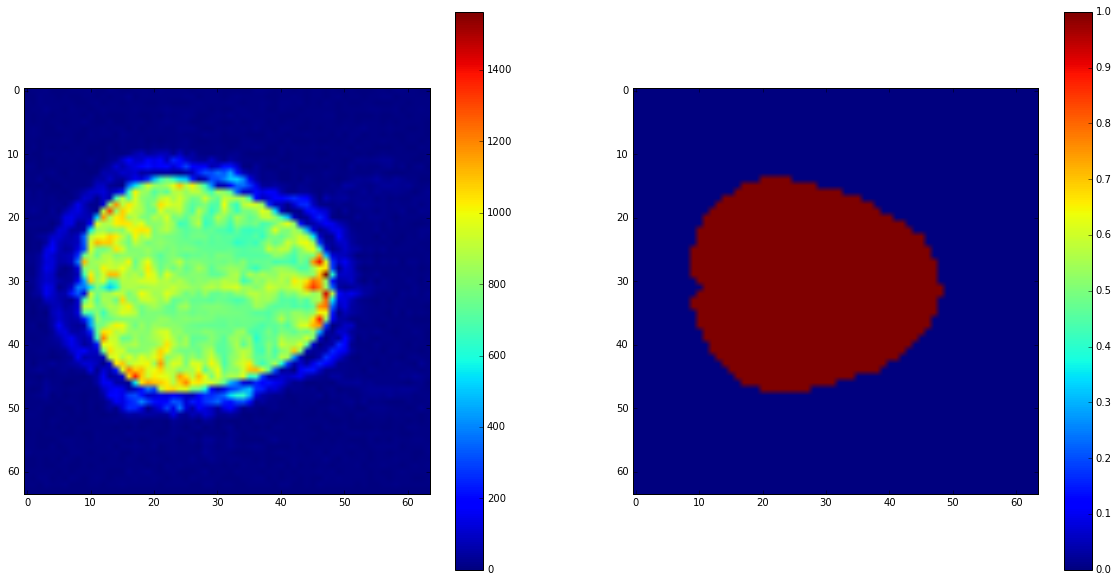

In [6]:
mask_b = compute_epi_mask(vol_nii).get_data().astype(bool)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(vol[:,:,20,10])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(mask_b[:,:,20],clim=(0.0, 1.))
plt.colorbar()

# Linear regression

In [7]:
def getspec(vol):
    nx,ny,nz = vol.shape
    nrows = int(np.ceil(np.sqrt(nz)))
    ncolumns = int(np.ceil(nz/(1.*nrows)))
    return nrows,ncolumns,nx,ny,nz

def montage(vol1):

    vol = np.swapaxes(vol1,0,1)
    nrows,ncolumns,nx,ny,nz = getspec(vol)

    mozaic = np.zeros((nrows*nx,ncolumns*ny))
    indx,indy = np.where(np.ones((nrows,ncolumns)))

    for ii in np.arange(vol.shape[2]):
        # we need to flip the image in the x axis
        mozaic[(indx[ii]*nx):((indx[ii]+1)*nx),(indy[ii]*ny):((indy[ii]+1)*ny)] = vol[::-1,:,ii]

    return mozaic





In [8]:
mask_b.astype(bool)

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, 

0.260504520922


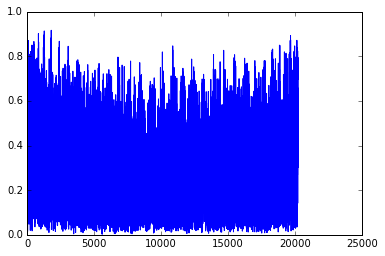

In [9]:

X = Xmotion
y = vol[mask_b].T

#mask = niak_mask_brain(vol);
#tseries = niak_vol2tseries(vol,mask);
#[beta_drifts,tseries] = niak_lse(tseries,Xdrifts);
#[beta_dmotion,Xmotion] = niak_lse(Xmotion,Xdrifts);

lreg_drift = LinearRegression(fit_intercept=True)
lreg_drift.fit(Xdrift,y)
new_y = y-lreg_drift.predict(Xdrift)

lreg_motion = LinearRegression(fit_intercept=True)
lreg_motion.fit(Xdrift,Xmotion)
new_Xmotion = Xmotion - lreg_motion.predict(Xdrift)

lreg = LinearRegression(fit_intercept=False)
lreg.fit(new_Xmotion,new_y)

ypred = lreg.predict(new_Xmotion)
R2 = getR2(new_y,ypred)

plt.plot(R2)

print R2.mean()

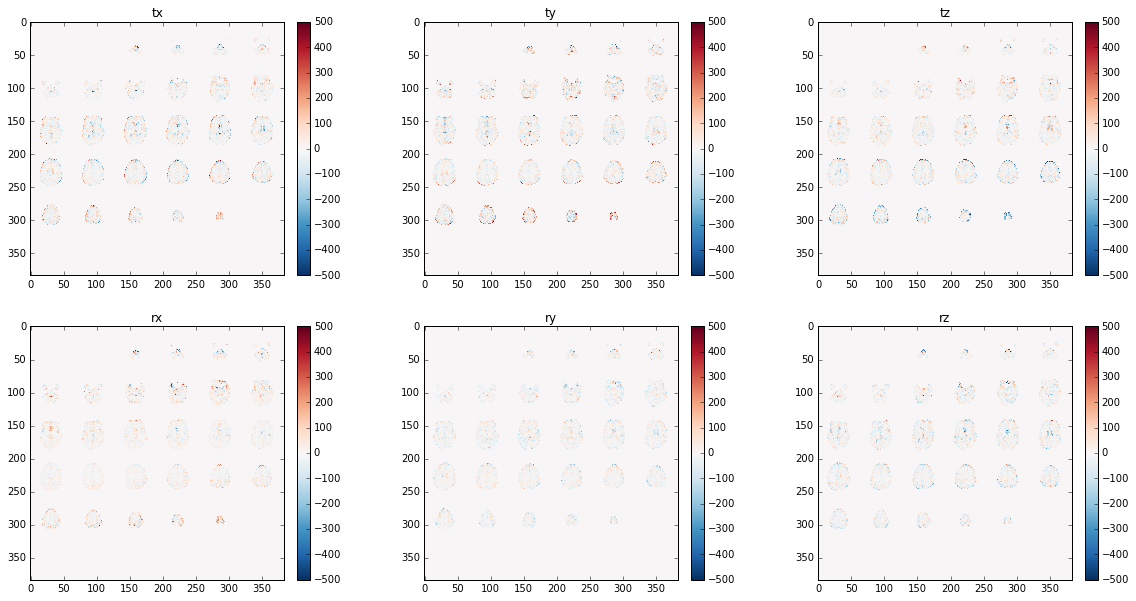

In [10]:
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
visu.mat(montage(getMap(lreg.coef_,mask_b)[:,:,:,0]),lim=[-500,500])
plt.title('tx')
plt.subplot(2,3,2)
visu.mat(montage(getMap(lreg.coef_,mask_b)[:,:,:,1]),lim=[-500,500])
plt.title('ty')
plt.subplot(2,3,3)
visu.mat(montage(getMap(lreg.coef_,mask_b)[:,:,:,2]),lim=[-500,500])
plt.title('tz')
plt.subplot(2,3,4)
visu.mat(montage(getMap(lreg.coef_,mask_b)[:,:,:,3]),lim=[-500,500])
plt.title('rx')
plt.subplot(2,3,5)
visu.mat(montage(getMap(lreg.coef_,mask_b)[:,:,:,4]),lim=[-500,500])
plt.title('ry')
plt.subplot(2,3,6)
visu.mat(montage(getMap(lreg.coef_,mask_b)[:,:,:,5]),lim=[-500,500])
plt.title('rz')


In [11]:
def show_diff(ref_vals,pred_vals,mask,frame=10,cut=20):
    plt.figure(figsize=(15,5))
    ref_vol = getMap(ref_vals[frame,:],mask)
    lim_val = [ref_vol[:,:,cut].min(),ref_vol[:,:,cut].max()]
    plt.subplot(1,3,1)
    visu.mat(getMap(ref_vals[frame,:],mask)[:,:,cut],lim=lim_val)
    plt.subplot(1,3,2)
    visu.mat(getMap(pred_vals[frame,:],mask)[:,:,cut],lim=lim_val)
    plt.subplot(1,3,3)
    visu.mat(getMap((ref_vals-pred_vals)[frame,:],mask)[:,:,cut],lim=lim_val)
    

In [12]:
def show_report(ref_vals,pred_vals,mask,frames,cut=20):
    n_frames = len(frames)
    # R2
    R2 = getR2(ref_vals,pred_vals)
    
    fig=plt.figure(figsize=(15,5+5*len(frames)))
    #plt.figure(figsize=(15,5))
    ax = plt.subplot(n_frames+1,2,1)
    plt.title('R2 Mean:'+str(round(R2.mean(),3))+' Min:'+str(round(R2.min(),3))+' Max:'+str(round(R2.max(),3)))
    #plt.suptitle('R2 Mean:'+str(R2.mean())+' Min:'+str(R2.min())+' Max:'+str(R2.max()), fontsize=10)
    #ax.text(0, 0, 'R2 Mean:'+str(R2.mean())+' Min:'+str(R2.min())+' Max:'+str(R2.max()), fontsize=10)
    #print 'R2 Mean:'+str(round(R2.mean(),3))+' Min:'+str(round(R2.min(),3))+' Max:'+str(round(R2.max(),3))
    visu.mat(getMap(R2,mask)[:,:,20],lim=[-1,1])
    plt.subplot(n_frames+1,2,2)
    plt.title('R2 distribution')
    plt.hist(R2,100)
    
    # frames
    for ii in range(n_frames):
        ref_vol = getMap(ref_vals[frames[ii],:],mask)
        lim_val = [ref_vol[:,:,cut].min(),ref_vol[:,:,cut].max()]
        plt.subplot(n_frames+1,3,3+3*ii+1)
        visu.mat(getMap(ref_vals[frames[ii],:],mask)[:,:,cut],lim=lim_val)
        if ii == 0: plt.title('Reference')
        plt.ylabel('Frame '+str(frames[ii]))
        plt.subplot(n_frames+1,3,3+3*ii+2)
        visu.mat(getMap(pred_vals[frames[ii],:],mask)[:,:,cut],lim=lim_val)
        if ii == 0: plt.title('Prediction')
        plt.subplot(n_frames+1,3,3+3*ii+3)
        visu.mat(getMap((ref_vals-pred_vals)[frames[ii],:],mask)[:,:,cut],lim=lim_val)
        if ii == 0: plt.title('Difference')
    

In [13]:

kf = KFold(n=vol.shape[3], n_folds=10, shuffle=False,random_state=None)

ts = vol[mask_b].T
pred_vals = []
ref_vals = []
for train, test in kf:
    
    #print test
    #print train
    #print ts.shape

    ## Train
    lreg_d = LinearRegression(fit_intercept=True,normalize=False)
    lreg_d.fit(Xdrift[train,:],ts[train,:])
    new_ts = ts-lreg_d.predict(Xdrift)
    
    lreg_md = LinearRegression(fit_intercept=True,normalize=False)
    lreg_md.fit(Xdrift[train,:],Xmotion[train,:])
    new_Xmotion = Xmotion - lreg_md.predict(Xdrift)
    
    # Learn the regression parameters to predict time series
    lreg_m = LinearRegression(fit_intercept=False,normalize=False)
    lreg_m.fit(new_Xmotion[train,:],new_ts[train,:])
    
    ## Test on independent data
    X_test = new_Xmotion[test,:]
    pred_vals.append(lreg_m.predict(X_test))
    
    ref_vals.append(new_ts[test,:])
    
    
    
print getR2(np.vstack(ref_vals),np.vstack(pred_vals)).mean()


0.0727610586566


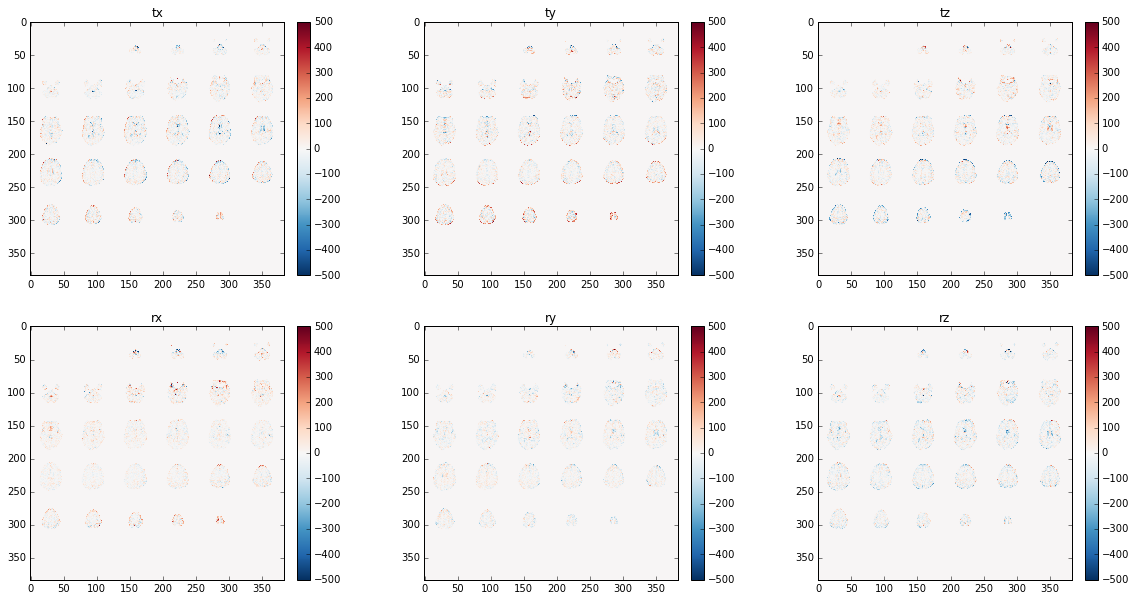

In [14]:
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
visu.mat(montage(getMap(lreg_m.coef_,mask_b)[:,:,:,0]),lim=[-500,500])
plt.title('tx')
plt.subplot(2,3,2)
visu.mat(montage(getMap(lreg_m.coef_,mask_b)[:,:,:,1]),lim=[-500,500])
plt.title('ty')
plt.subplot(2,3,3)
visu.mat(montage(getMap(lreg_m.coef_,mask_b)[:,:,:,2]),lim=[-500,500])
plt.title('tz')
plt.subplot(2,3,4)
visu.mat(montage(getMap(lreg_m.coef_,mask_b)[:,:,:,3]),lim=[-500,500])
plt.title('rx')
plt.subplot(2,3,5)
visu.mat(montage(getMap(lreg_m.coef_,mask_b)[:,:,:,4]),lim=[-500,500])
plt.title('ry')
plt.subplot(2,3,6)
visu.mat(montage(getMap(lreg_m.coef_,mask_b)[:,:,:,5]),lim=[-500,500])
plt.title('rz')


[ 0.48883843  0.60653567  0.4345842   0.26702386  0.21917324  0.40170175
  0.41339895  0.37901482  0.39835516  0.2093654 ]


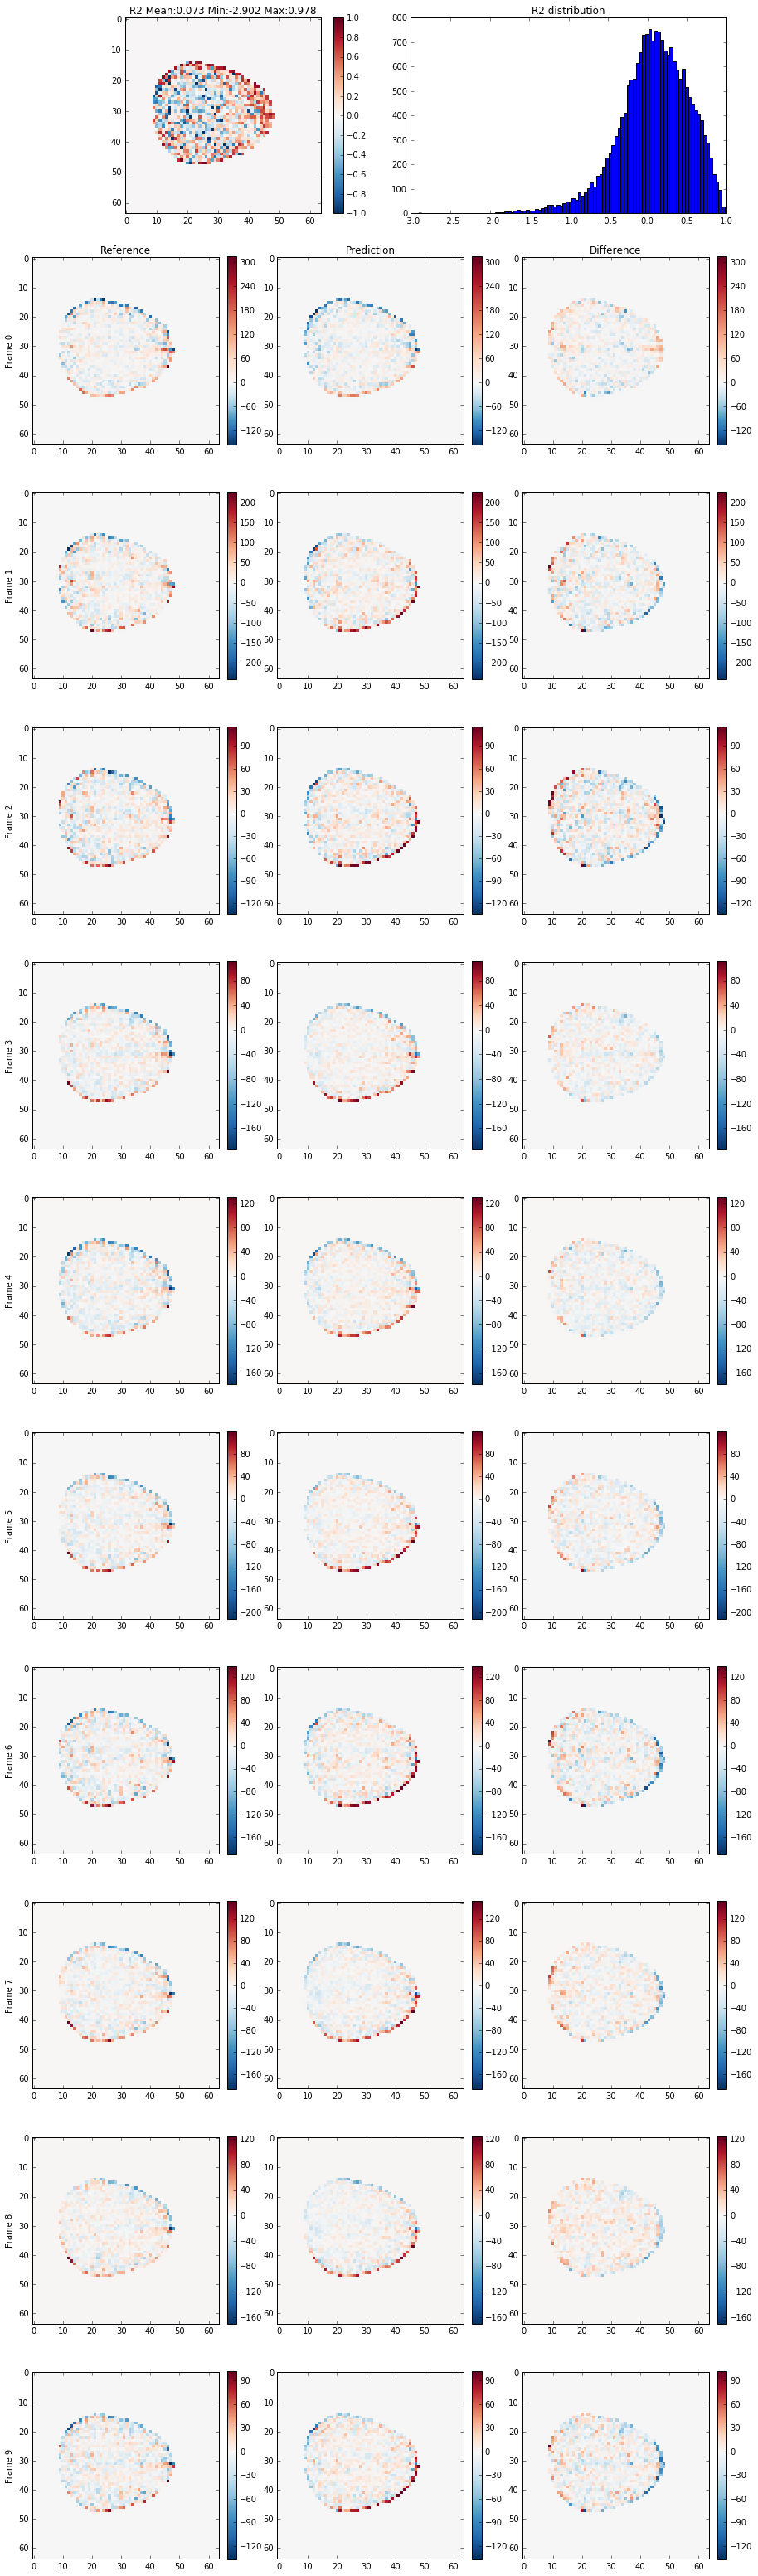

In [15]:
show_report(np.vstack(ref_vals),np.vstack(pred_vals),mask_b,frames=np.arange(0,10))
print fd[0:10]

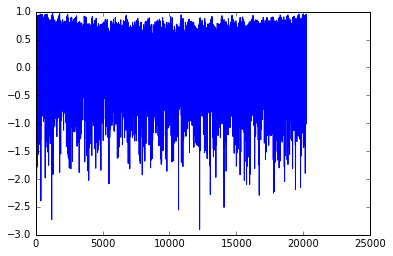

In [16]:
plt.plot(getR2(np.vstack(ref_vals),np.vstack(pred_vals)))

# Fully connected 1 layer

In [17]:
X.shape,y.shape,new_ts.shape

((150, 6), (150, 20220), (150, 20220))

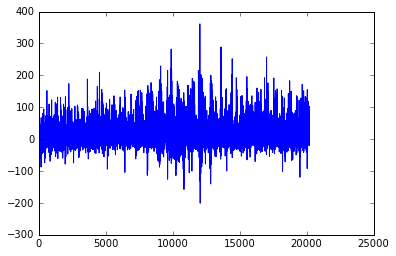

In [18]:
plt.plot(new_ts[0,:])

In [19]:
# no normalization

Using Theano backend.
Using gpu device 0: GeForce GTX 550 Ti (CNMeM is disabled, cuDNN not available)

--------------------kfold 1--------------------
Train on 108 samples, validate on 27 samples
Epoch 1/50
108/108 [==============================] - 0s - loss: 138.2188 - val_loss: 143.4838
Epoch 2/50
108/108 [==============================] - 0s - loss: 127.5509 - val_loss: 137.6094
Epoch 3/50
108/108 [==============================] - 0s - loss: 117.4577 - val_loss: 134.6401
Epoch 4/50
108/108 [==============================] - 0s - loss: 111.3645 - val_loss: 133.4714
Epoch 5/50
108/108 [==============================] - 0s - loss: 108.1208 - val_loss: 132.8780
Epoch 6/50
108/108 [==============================] - 0s - loss: 106.1542 - val_loss: 132.3958
Epoch 7/50
108/108 [==============================] - 0s - loss: 104.7569 - val_loss: 132.0032
Epoch 8/50
108/108 [==============================] - 0s - loss: 103.7584 - val_loss: 131.7437
Epoch 9/50
108/108 [==============================] - 0s - loss: 103.0847 - val_loss: 131.6075
Epoch 10/50
108/108 [==============================]

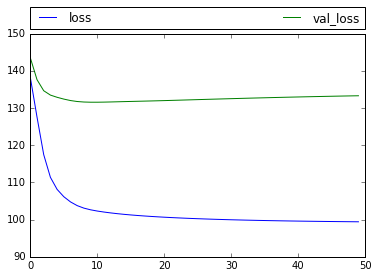

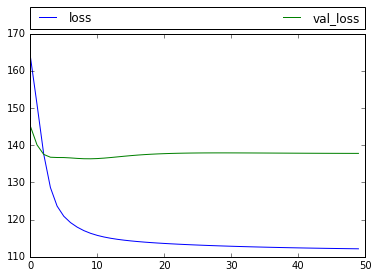

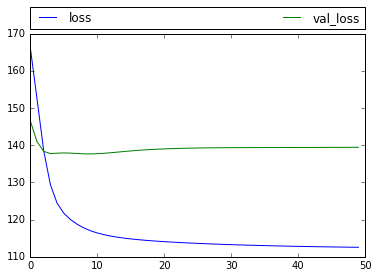

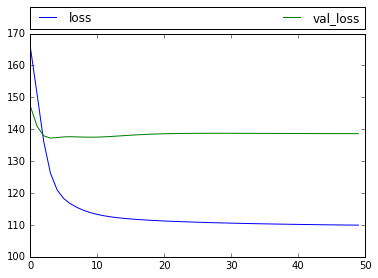

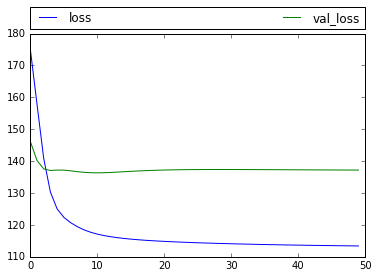

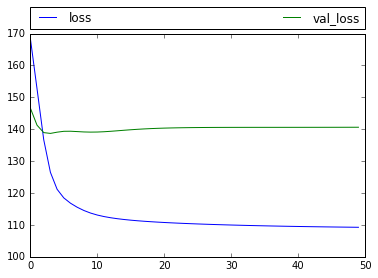

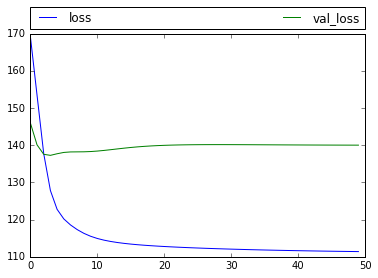

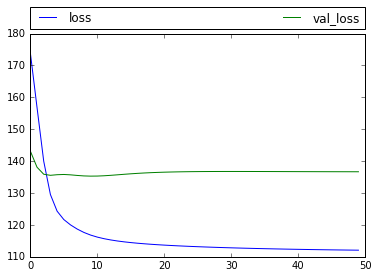

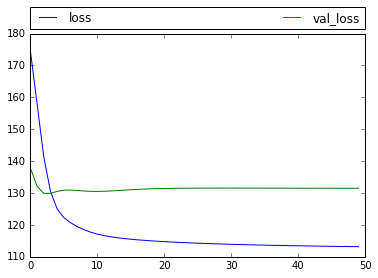

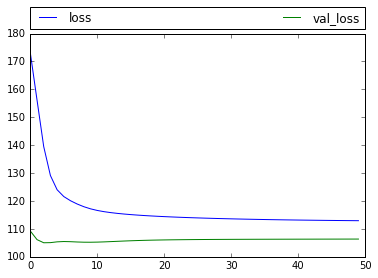

In [20]:
from keras.utils import np_utils, generic_utils
from keras.optimizers import SGD, RMSprop
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.preprocessing import StandardScaler

def build_model():
    model = Sequential()
    model.add(Dense(y.shape[1], input_dim=6,init='uniform'))
    model.add(Activation('linear'))

    sgd = SGD(lr=1000, decay=0., momentum=0.5, nesterov=False)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    return model


ts = vol[mask_b].T
nb_epoch = 50
kf = KFold(n=ts.shape[0], n_folds=10, shuffle=False,random_state=None)

pred_vals = []
ref_vals = []
k=1
for train, test in kf:
    
    ssx = StandardScaler()
    #ssy = StandardScaler()
    #print train
    print ('-'*20)+'kfold '+ str(k)+('-'*20)
    k+=1
    # Train
    lreg_d = LinearRegression(fit_intercept=True,normalize=False)
    lreg_d.fit(Xdrift[train,:],ts[train,:])
    new_ts = ts-lreg_d.predict(Xdrift)
    
    lreg_md = LinearRegression(fit_intercept=True,normalize=False)
    lreg_md.fit(Xdrift[train,:],Xmotion[train,:])
    new_Xmotion = Xmotion - lreg_md.predict(Xdrift)
    
    # Learn the regression parameters to predict time series
    model = build_model()
    hist = model.fit(ssx.fit_transform(new_Xmotion[train,:]), new_ts[train,:], nb_epoch=nb_epoch, batch_size=ts.shape[0],validation_split=0.2)
    
    plt.figure()
    plt.plot(range(nb_epoch),hist.history['loss'],range(nb_epoch),hist.history['val_loss'])
    #plt.plot(range(nb_epoch),hist.history['loss'])
    plt.legend(['loss','val_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    #lreg_m = LinearRegression(fit_intercept=False)
    #lreg_m.fit(Xmotion.values[train,:],new_ts)
    
    
    ## Test on independent data
    X_test = ssx.transform(new_Xmotion[test,:])
    pred_vals.append(model.predict(X_test))
    
    ref_vals.append(new_ts[test,:])
    
    
    
print getR2(np.vstack(ref_vals),np.vstack(pred_vals)).mean()


[ 0.48883843  0.60653567  0.4345842   0.26702386  0.21917324  0.40170175
  0.41339895  0.37901482  0.39835516  0.2093654 ]


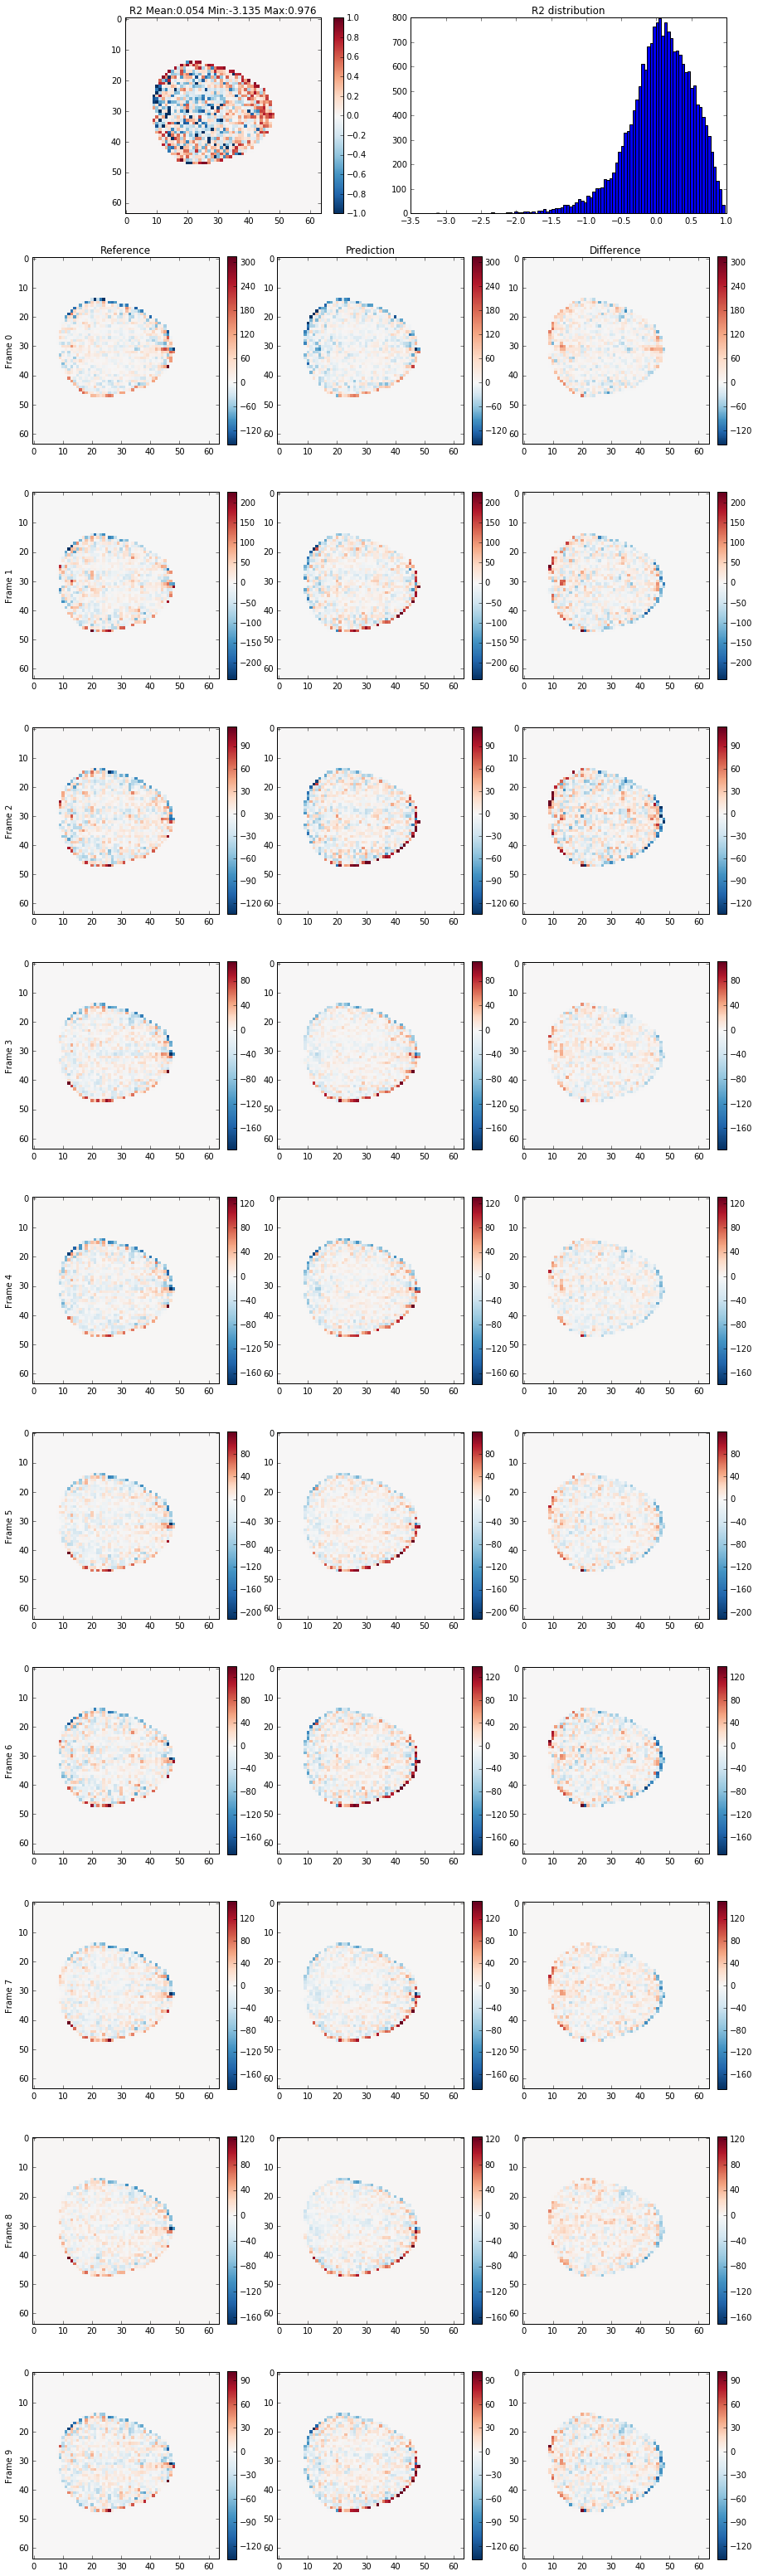

In [21]:
show_report(np.vstack(ref_vals),np.vstack(pred_vals),mask_b,frames=np.arange(0,10))
print fd[0:10]

--------------------kfold 1--------------------
Train on 108 samples, validate on 27 samples
Epoch 1/50
108/108 [==============================] - 0s - loss: 0.9897 - val_loss: 1.0652
Epoch 2/50
108/108 [==============================] - 0s - loss: 0.9882 - val_loss: 1.0636
Epoch 3/50
108/108 [==============================] - 0s - loss: 0.9854 - val_loss: 1.0613
Epoch 4/50
108/108 [==============================] - 0s - loss: 0.9815 - val_loss: 1.0584
Epoch 5/50
108/108 [==============================] - 0s - loss: 0.9766 - val_loss: 1.0551
Epoch 6/50
108/108 [==============================] - 0s - loss: 0.9708 - val_loss: 1.0514
Epoch 7/50
108/108 [==============================] - 0s - loss: 0.9645 - val_loss: 1.0474
Epoch 8/50
108/108 [==============================] - 0s - loss: 0.9576 - val_loss: 1.0433
Epoch 9/50
108/108 [==============================] - 0s - loss: 0.9504 - val_loss: 1.0391
Epoch 10/50
108/108 [==============================] - 0s - loss: 0.9429 - val_loss: 1.0

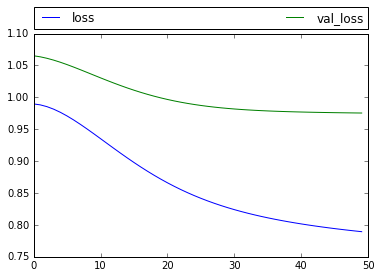

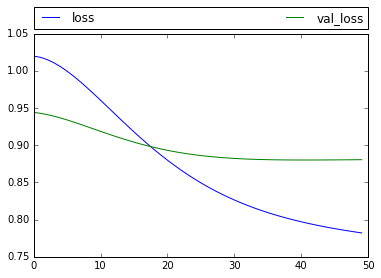

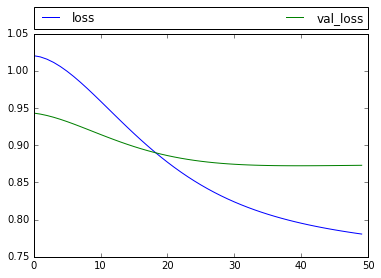

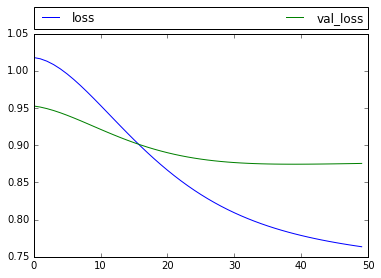

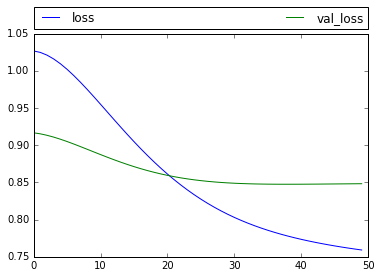

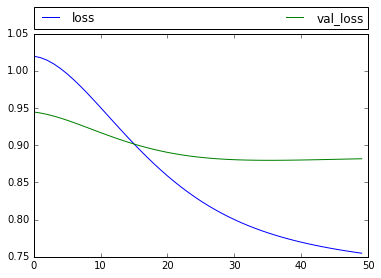

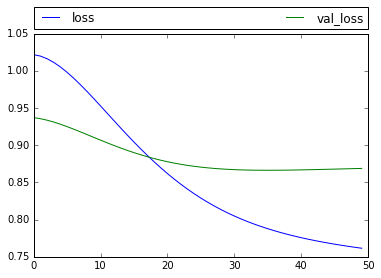

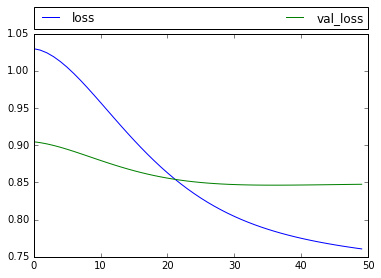

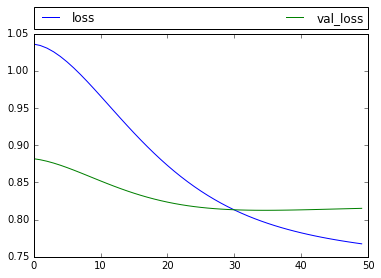

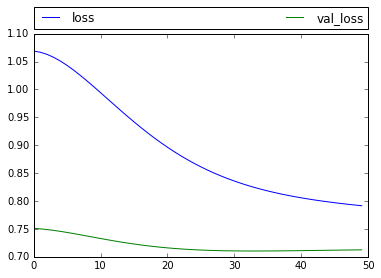

In [22]:
from keras.utils import np_utils, generic_utils
from keras.optimizers import SGD, RMSprop
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.preprocessing import StandardScaler

def build_model(output_size):
    model = Sequential()
    model.add(Dense(output_size, input_dim=6,init='uniform'))
    model.add(Activation('linear'))

    sgd = SGD(lr=20, decay=0.0, momentum=0.9, nesterov=False)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    return model


ts = vol[mask_b].T
nb_epoch = 50
kf = KFold(n=ts.shape[0], n_folds=10, shuffle=False,random_state=None)

pred_vals = []
ref_vals = []
k=1
for train, test in kf:
    
    ssx = StandardScaler()
    ssy = StandardScaler()
    #print train
    print ('-'*20)+'kfold '+ str(k)+('-'*20)
    k+=1
    # Train
    lreg_d = LinearRegression(fit_intercept=True,normalize=False)
    lreg_d.fit(Xdrift[train,:],ts[train,:])
    new_ts = ts-lreg_d.predict(Xdrift)
    
    lreg_md = LinearRegression(fit_intercept=True,normalize=False)
    lreg_md.fit(Xdrift[train,:],Xmotion[train,:])
    new_Xmotion = Xmotion - lreg_md.predict(Xdrift)
    
    # Learn the regression parameters to predict time series
    model = build_model(ts.shape[1])
    hist = model.fit(ssx.fit_transform(new_Xmotion[train,:]), ssy.fit_transform(new_ts[train,:]), nb_epoch=nb_epoch, batch_size=ts.shape[0],validation_split=0.2)
    
    plt.figure()
    plt.plot(range(nb_epoch),hist.history['loss'],range(nb_epoch),hist.history['val_loss'])
    #plt.plot(range(nb_epoch),hist.history['loss'])
    plt.legend(['loss','val_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    #lreg_m = LinearRegression(fit_intercept=False)
    #lreg_m.fit(Xmotion.values[train,:],new_ts)
    
    ## Test on independent data
    X_test = ssx.transform(new_Xmotion[test,:])
    pred_vals.append(ssy.inverse_transform(model.predict(X_test)))
    
    ref_vals.append(new_ts[test,:])
    
    
print getR2(np.vstack(ref_vals),np.vstack(pred_vals)).mean()


[ 0.48883843  0.60653567  0.4345842   0.26702386  0.21917324  0.40170175
  0.41339895  0.37901482  0.39835516  0.2093654 ]


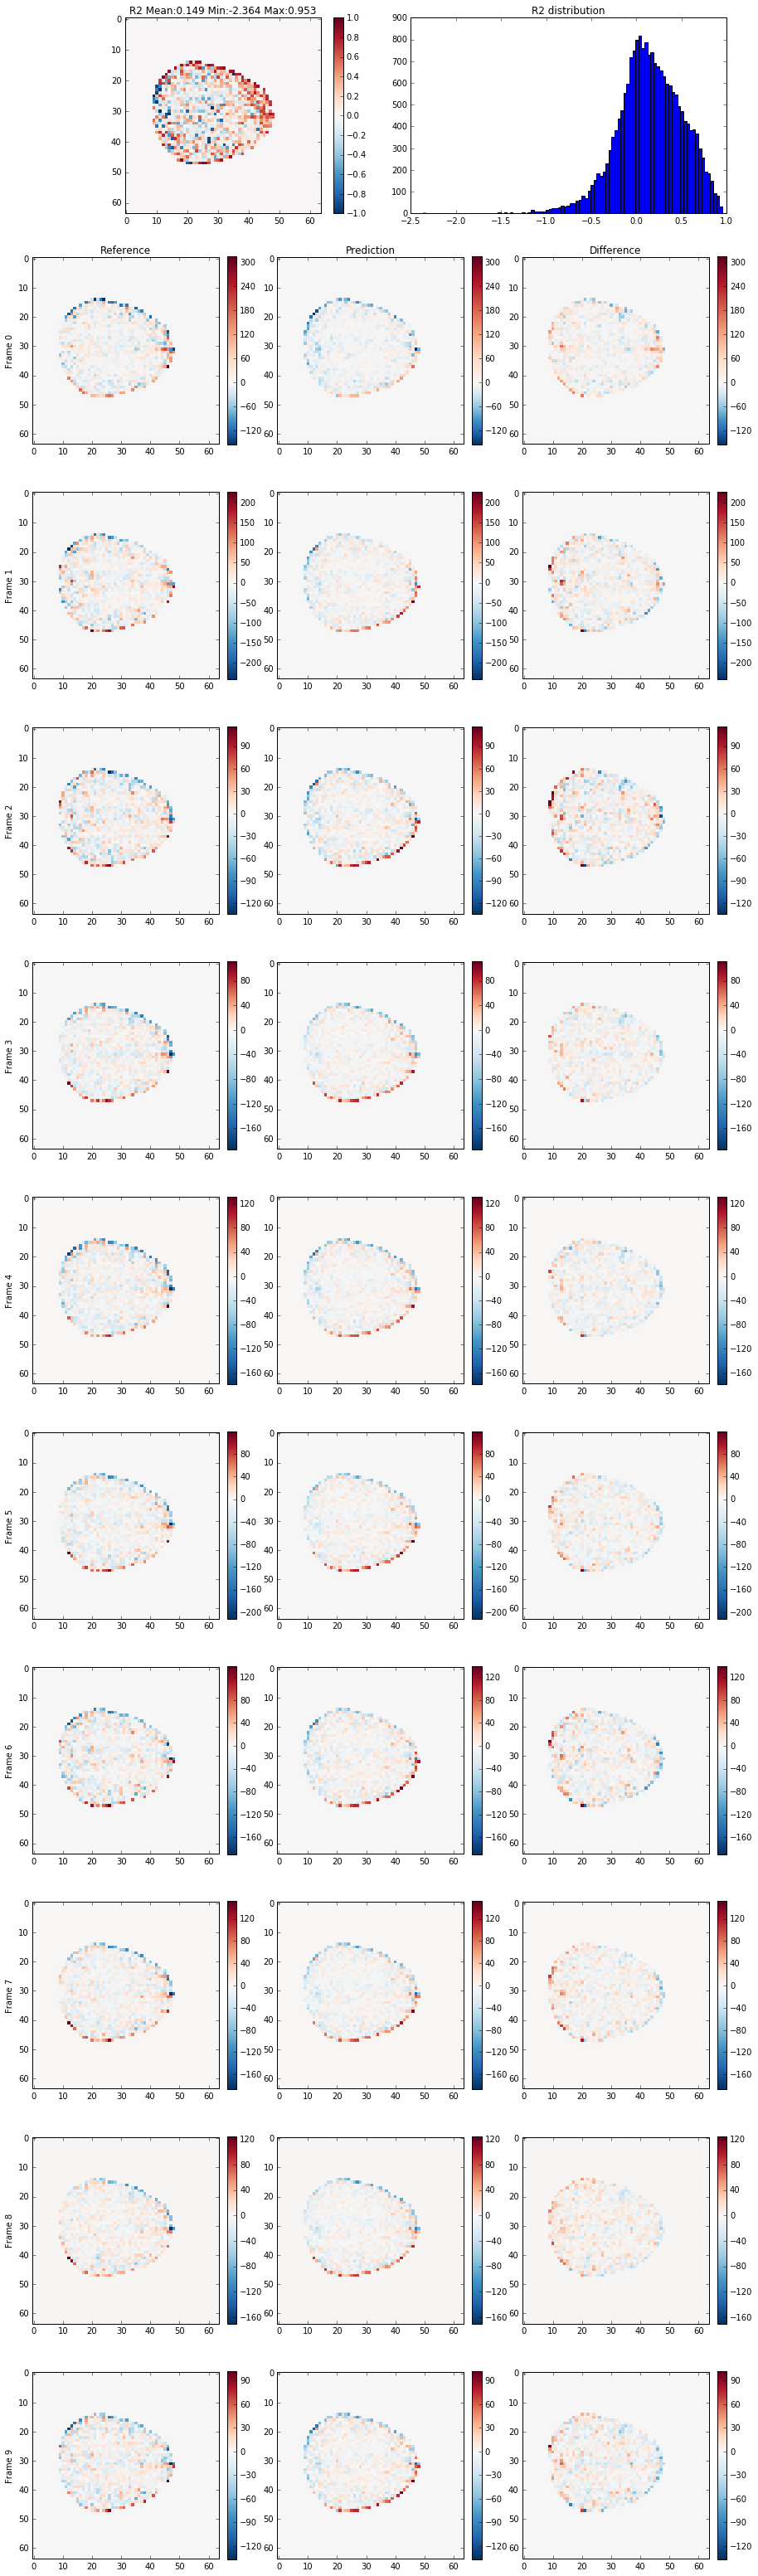

In [23]:
show_report(np.vstack(ref_vals),np.vstack(pred_vals),mask_b,frames=np.arange(0,10))
print fd[0:10]

# 1 hidden relu layer

--------------------kfold 1--------------------
--------------------kfold 2--------------------
--------------------kfold 3--------------------
--------------------kfold 4--------------------
--------------------kfold 5--------------------
--------------------kfold 6--------------------
--------------------kfold 7--------------------
--------------------kfold 8--------------------
--------------------kfold 9--------------------
--------------------kfold 10--------------------
0.106091600725


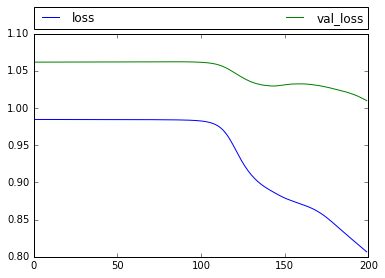

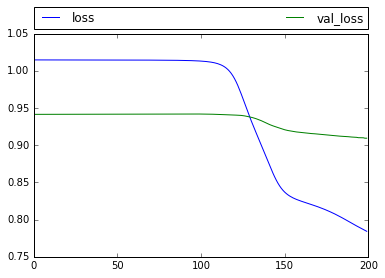

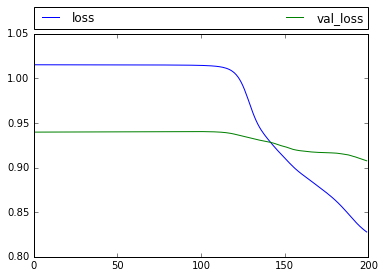

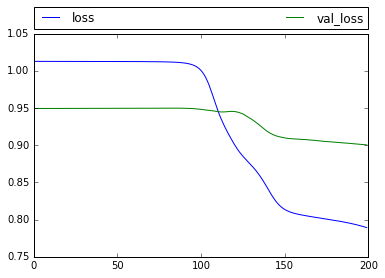

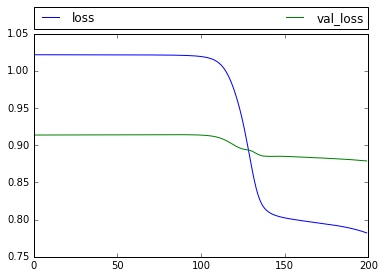

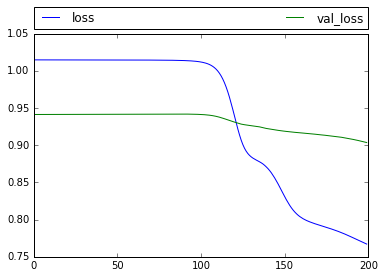

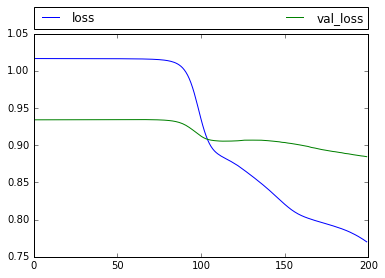

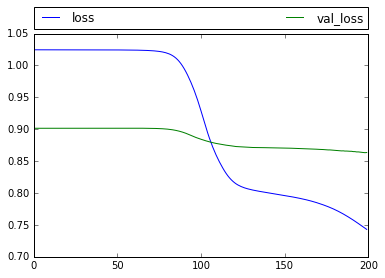

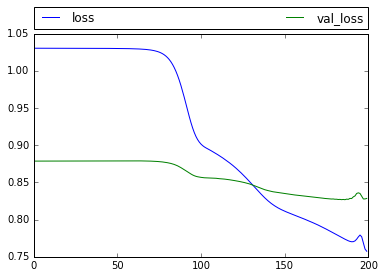

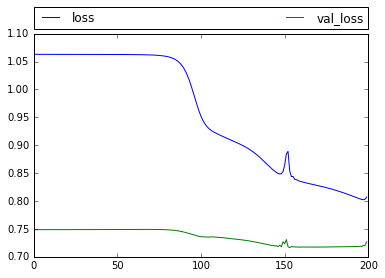

In [24]:
from keras.utils import np_utils, generic_utils
from keras.optimizers import SGD, RMSprop
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import StandardScaler


def build_model(output_size):
    model = Sequential()
    model.add(Dense(32, input_dim=6,init='uniform'))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(32,init='uniform'))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(output_size,init='uniform'))
    #model.add(BatchNormalization())
    model.add(Activation('linear'))

    #sgd = SGD(lr=20, decay=0.0, momentum=0.5, nesterov=False)
    sgd = SGD(lr=15, decay=0.0, momentum=0.5, nesterov=False)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    return model


nb_epoch = 200
#nb_epoch = 100
validation_split = 0.2
ts = vol[mask_b].T
kf = KFold(n=ts.shape[0], n_folds=10, shuffle=False,random_state=None)

pred_vals = []
ref_vals = []
k=1
for train, test in kf:
    
    ssx = StandardScaler()
    ssy = StandardScaler()
    
    #print train
    print ('-'*20)+'kfold '+ str(k)+('-'*20)
    k+=1
     # Train
    lreg_d = LinearRegression(fit_intercept=True,normalize=False)
    lreg_d.fit(Xdrift[train,:],ts[train,:])
    new_ts = ts-lreg_d.predict(Xdrift)
    
    lreg_md = LinearRegression(fit_intercept=True,normalize=False)
    lreg_md.fit(Xdrift[train,:],Xmotion[train,:])
    new_Xmotion = Xmotion - lreg_md.predict(Xdrift)
    
    # Learn the regression parameters to predict time series
    model = build_model(ts.shape[1])
    hist = model.fit(ssx.fit_transform(new_Xmotion[train,:]), ssy.fit_transform(new_ts[train,:]),verbose=0, nb_epoch=nb_epoch, batch_size=ts.shape[0],validation_split=validation_split)
    
    plt.figure()
    if validation_split == 0.:
        plt.plot(range(nb_epoch),hist.history['loss'])
    else:
        plt.plot(range(nb_epoch),hist.history['loss'],range(nb_epoch),hist.history['val_loss'])
    plt.legend(['loss','val_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    #lreg_m = LinearRegression(fit_intercept=False)
    #lreg_m.fit(Xmotion.values[train,:],new_ts)
    
    ## Test on independent data
    X_test = ssx.transform(new_Xmotion[test,:])
    pred_vals.append(ssy.inverse_transform(model.predict(X_test)))
    
    ref_vals.append(new_ts[test,:])
    
    
    
print getR2(np.vstack(ref_vals),np.vstack(pred_vals)).mean()


[ 0.48883843  0.60653567  0.4345842   0.26702386  0.21917324  0.40170175
  0.41339895  0.37901482  0.39835516  0.2093654 ]


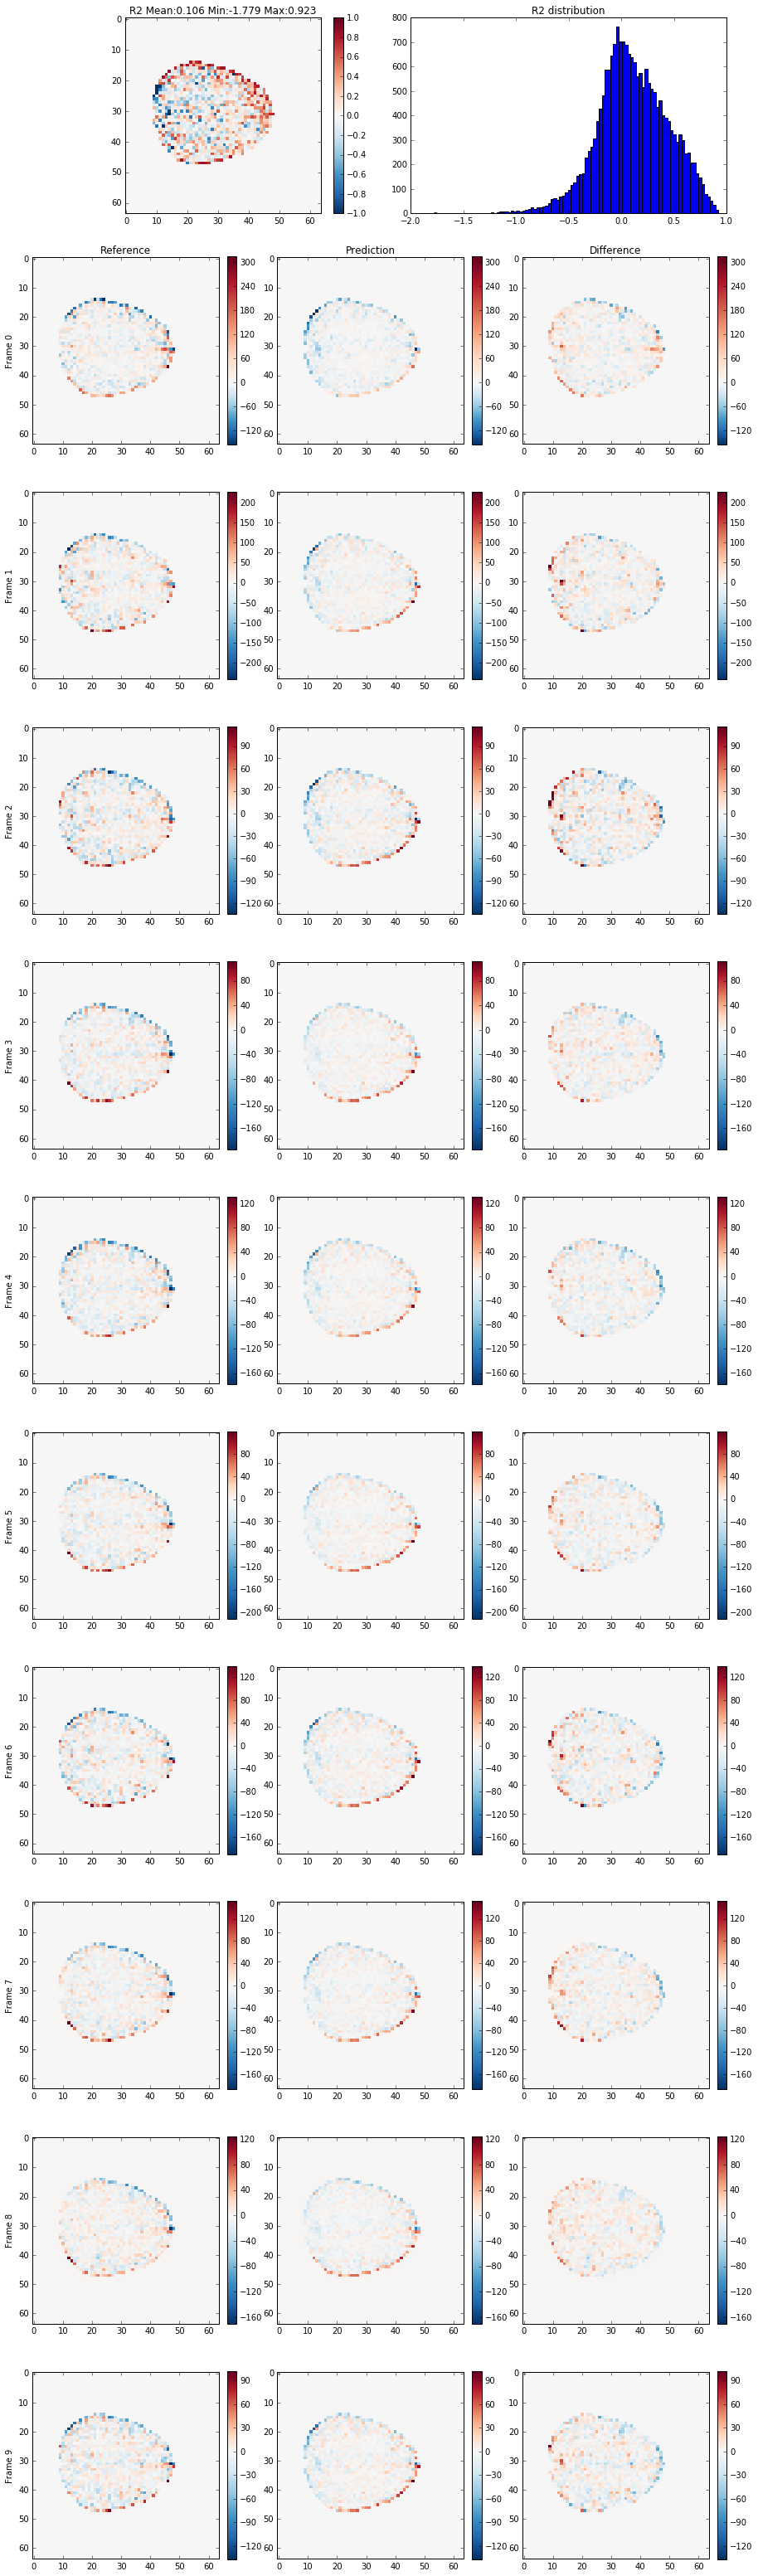

In [25]:
show_report(np.vstack(ref_vals),np.vstack(pred_vals),mask_b,frames=np.arange(0,10))
print fd[0:10]

--------------------kfold 1--------------------
--------------------kfold 2--------------------
--------------------kfold 3--------------------
--------------------kfold 4--------------------
--------------------kfold 5--------------------
--------------------kfold 6--------------------
--------------------kfold 7--------------------
--------------------kfold 8--------------------
--------------------kfold 9--------------------
--------------------kfold 10--------------------
0.140929532728


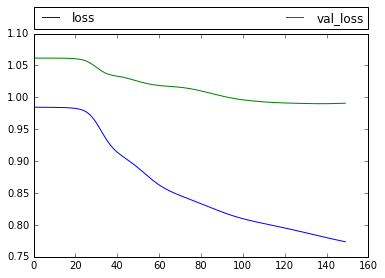

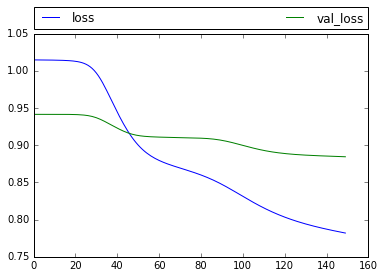

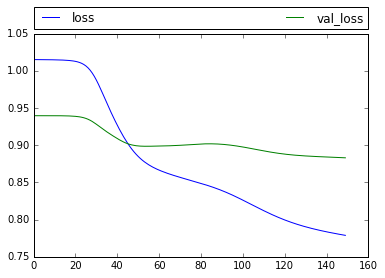

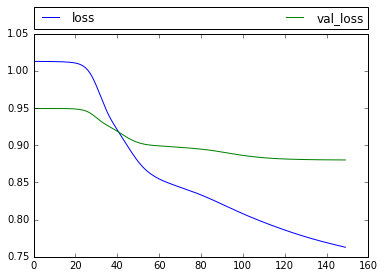

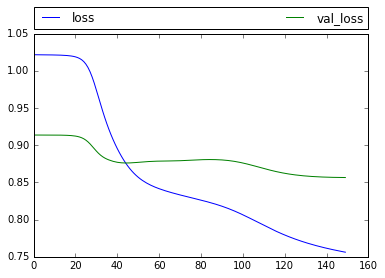

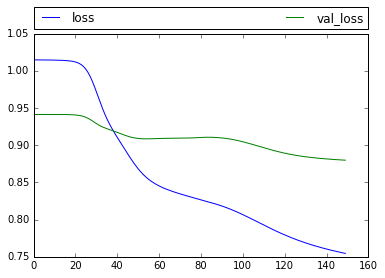

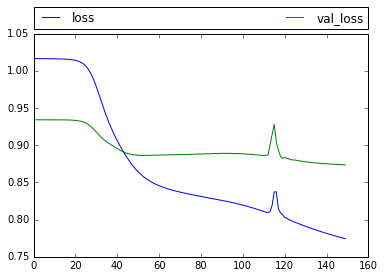

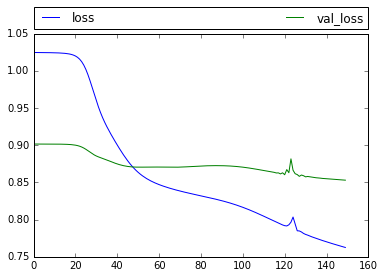

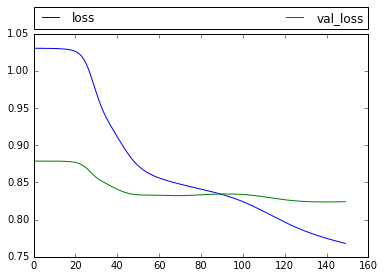

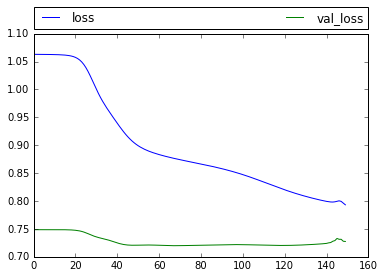

In [26]:
from keras.utils import np_utils, generic_utils
from keras.optimizers import SGD, RMSprop
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import StandardScaler


def build_model(output_size):
    model = Sequential()
    model.add(Dense(64, input_dim=6,init='uniform'))
    #model.add(BatchNormalization())
    model.add(Activation('tanh'))
    
    model.add(Dense(64,init='uniform'))
    #model.add(BatchNormalization())
    model.add(Activation('tanh'))

    model.add(Dense(output_size,init='uniform'))
    #model.add(BatchNormalization())
    model.add(Activation('linear'))

    sgd = SGD(lr=20, decay=0.00, momentum=0.5, nesterov=False)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    return model


nb_epoch = 150
validation_split = 0.2
ts = vol[mask_b].T
kf = KFold(n=ts.shape[0], n_folds=10, shuffle=False,random_state=None)

pred_vals = []
ref_vals = []
k=1
for train, test in kf:
    
    ssx = StandardScaler()
    ssy = StandardScaler()
    
    #print train
    print ('-'*20)+'kfold '+ str(k)+('-'*20)
    k+=1
     # Train
    lreg_d = LinearRegression(fit_intercept=True,normalize=False)
    lreg_d.fit(Xdrift[train,:],ts[train,:])
    new_ts = ts-lreg_d.predict(Xdrift)
    
    lreg_md = LinearRegression(fit_intercept=True,normalize=False)
    lreg_md.fit(Xdrift[train,:],Xmotion[train,:])
    new_Xmotion = Xmotion - lreg_md.predict(Xdrift)
    
    # Learn the regression parameters to predict time series
    model = build_model(ts.shape[1])
    hist = model.fit(ssx.fit_transform(new_Xmotion[train,:]), ssy.fit_transform(new_ts[train,:]),verbose=0, nb_epoch=nb_epoch, batch_size=ts.shape[0],validation_split=validation_split)
    
    plt.figure()
    if validation_split == 0.:
        plt.plot(range(nb_epoch),hist.history['loss'])
    else:
        plt.plot(range(nb_epoch),hist.history['loss'],range(nb_epoch),hist.history['val_loss'])
    plt.legend(['loss','val_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    #lreg_m = LinearRegression(fit_intercept=False)
    #lreg_m.fit(Xmotion.values[train,:],new_ts)
    
    ## Test on independent data
    X_test = ssx.transform(new_Xmotion[test,:])
    pred_vals.append(ssy.inverse_transform(model.predict(X_test)))
    
    ref_vals.append(new_ts[test,:])
    
    
    
print getR2(np.vstack(ref_vals),np.vstack(pred_vals)).mean()


[ 0.48883843  0.60653567  0.4345842   0.26702386  0.21917324  0.40170175
  0.41339895  0.37901482  0.39835516  0.2093654 ]


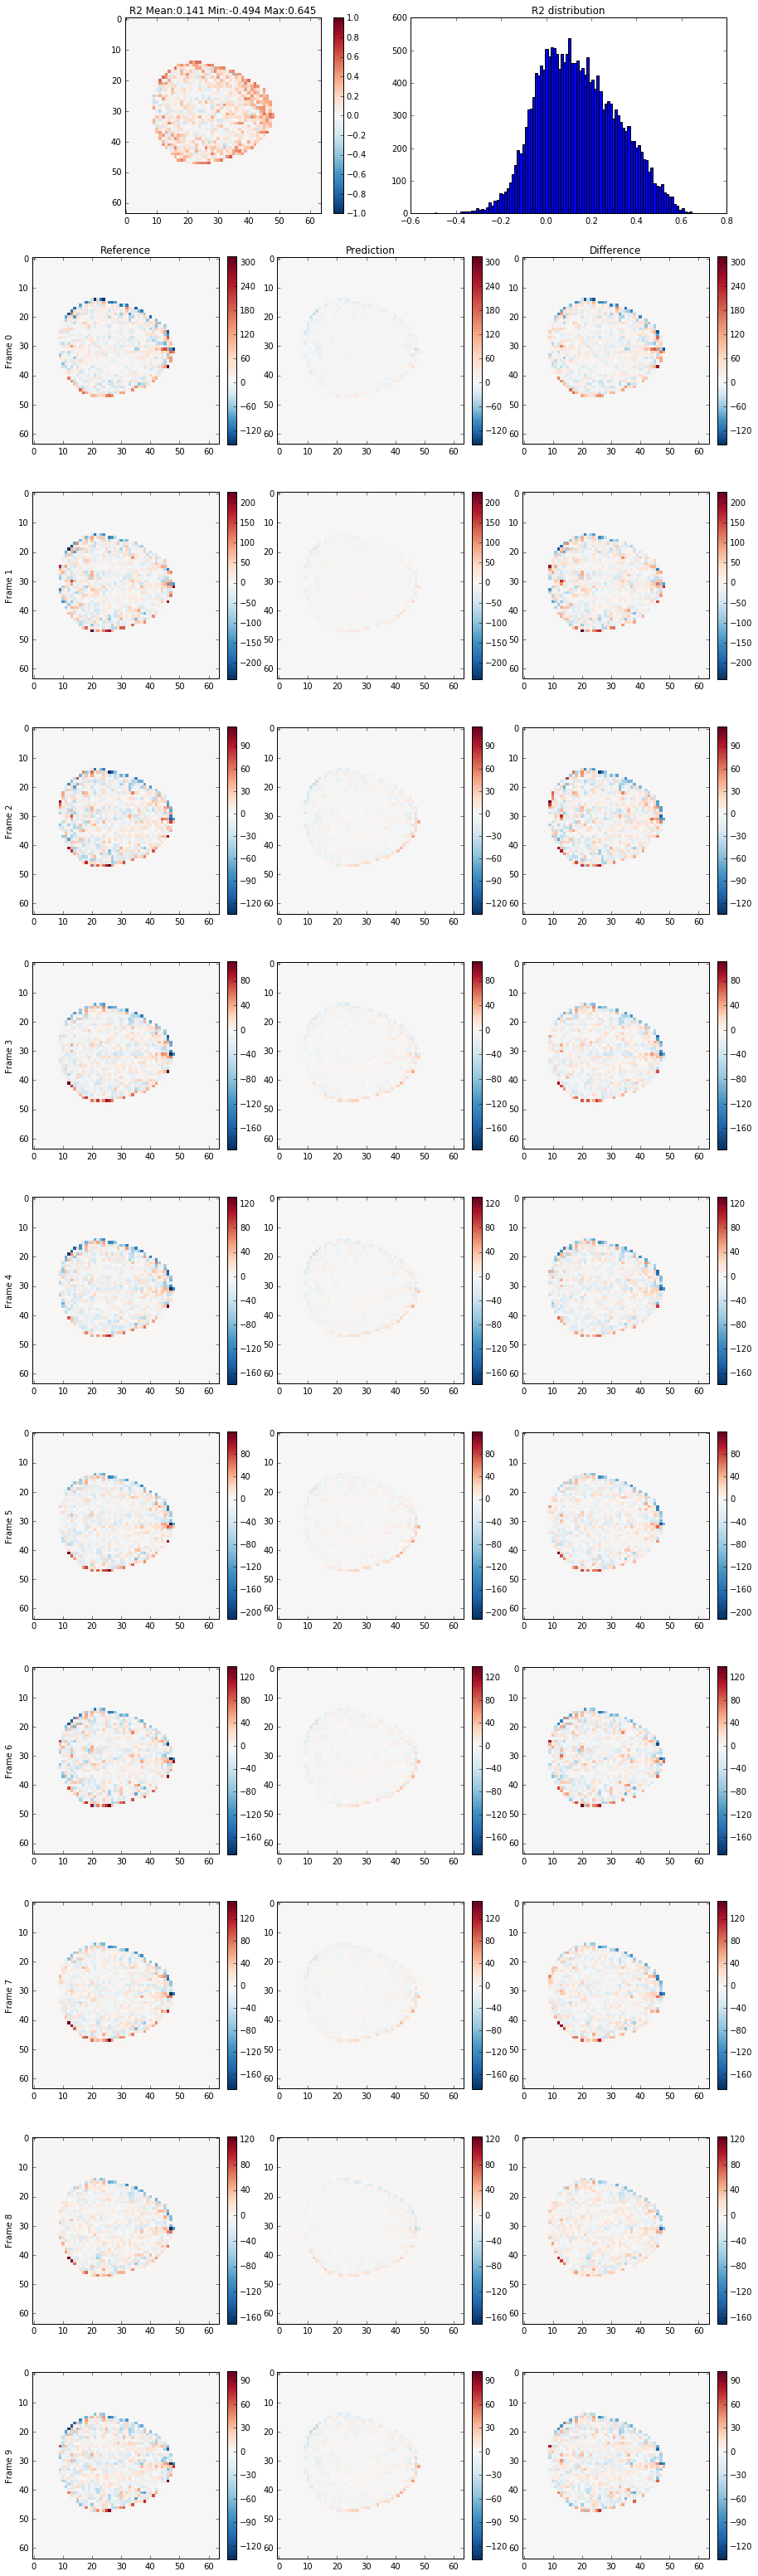

In [27]:
show_report(np.vstack(ref_vals),np.vstack(pred_vals),mask_b,frames=np.arange(0,10))
print fd[0:10]

--------------------kfold 1--------------------
--------------------kfold 2--------------------
--------------------kfold 3--------------------
--------------------kfold 4--------------------
--------------------kfold 5--------------------
--------------------kfold 6--------------------
--------------------kfold 7--------------------
--------------------kfold 8--------------------
--------------------kfold 9--------------------
--------------------kfold 10--------------------
0.170894518343


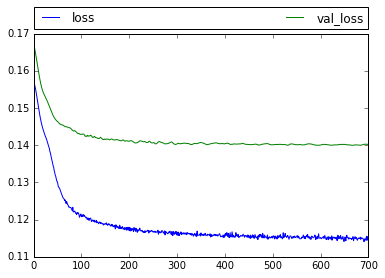

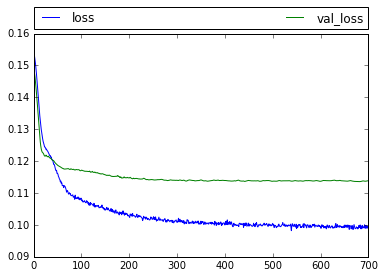

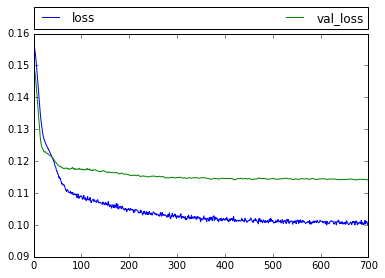

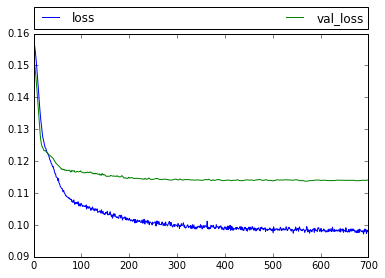

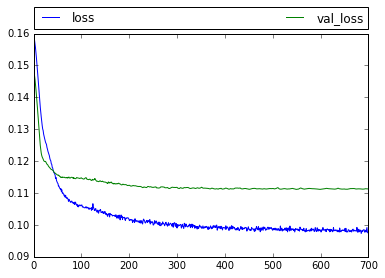

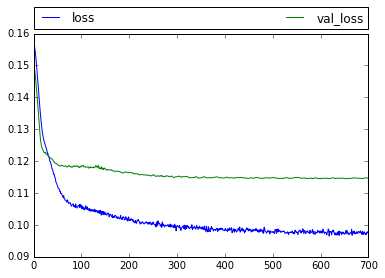

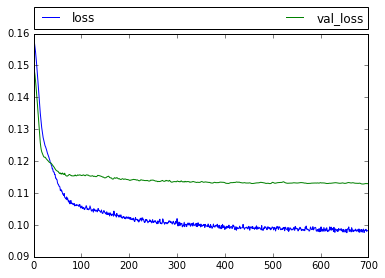

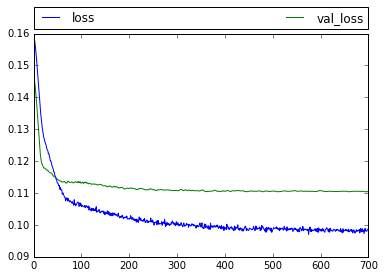

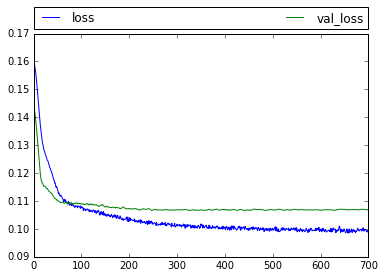

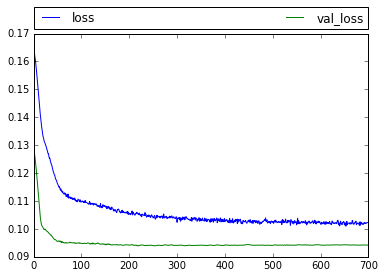

In [28]:
from keras.utils import np_utils, generic_utils
from keras.optimizers import SGD, RMSprop
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from sklearn.preprocessing import StandardScaler,MinMaxScaler


def build_model(output_size):
    model = Sequential()
    model.add(Dense(128, input_dim=6,init='uniform'))
    #model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128,init='uniform'))
    #model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))

    model.add(Dense(output_size,init='uniform'))
    #model.add(BatchNormalization())
    model.add(Activation('linear'))

    sgd = SGD(lr=70, decay=0.04, momentum=0.9, nesterov=False)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    return model


nb_epoch = 700
validation_split = 0.2
ts = vol[mask_b].T
kf = KFold(n=ts.shape[0], n_folds=10, shuffle=False,random_state=None)

pred_vals = []
ref_vals = []
k=1
for train, test in kf:
    
    ssx = MinMaxScaler(feature_range=(-1,1))#StandardScaler()
    ssy = MinMaxScaler(feature_range=(-1,1))#StandardScaler()
    
    #print train
    print ('-'*20)+'kfold '+ str(k)+('-'*20)
    k+=1
     # Train
    lreg_d = LinearRegression(fit_intercept=True,normalize=False)
    lreg_d.fit(Xdrift[train,:],ts[train,:])
    new_ts = ts-lreg_d.predict(Xdrift)
    
    lreg_md = LinearRegression(fit_intercept=True,normalize=False)
    lreg_md.fit(Xdrift[train,:],Xmotion[train,:])
    new_Xmotion = Xmotion - lreg_md.predict(Xdrift)
    
    # Learn the regression parameters to predict time series
    model = build_model(ts.shape[1])
    hist = model.fit(ssx.fit_transform(new_Xmotion[train,:]), ssy.fit_transform(new_ts[train,:]),verbose=0, nb_epoch=nb_epoch, batch_size=ts.shape[0],validation_split=validation_split)
    
    plt.figure()
    if validation_split == 0.:
        plt.plot(range(nb_epoch),hist.history['loss'])
    else:
        plt.plot(range(nb_epoch),hist.history['loss'],range(nb_epoch),hist.history['val_loss'])
    plt.legend(['loss','val_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    #lreg_m = LinearRegression(fit_intercept=False)
    #lreg_m.fit(Xmotion.values[train,:],new_ts)
    
    ## Test on independent data
    X_test = ssx.transform(new_Xmotion[test,:])
    pred_vals.append(ssy.inverse_transform(model.predict(X_test)))
    
    ref_vals.append(new_ts[test,:])
    
    
    
print getR2(np.vstack(ref_vals),np.vstack(pred_vals)).mean()


[ 0.48883843  0.60653567  0.4345842   0.26702386  0.21917324  0.40170175
  0.41339895  0.37901482  0.39835516  0.2093654 ]


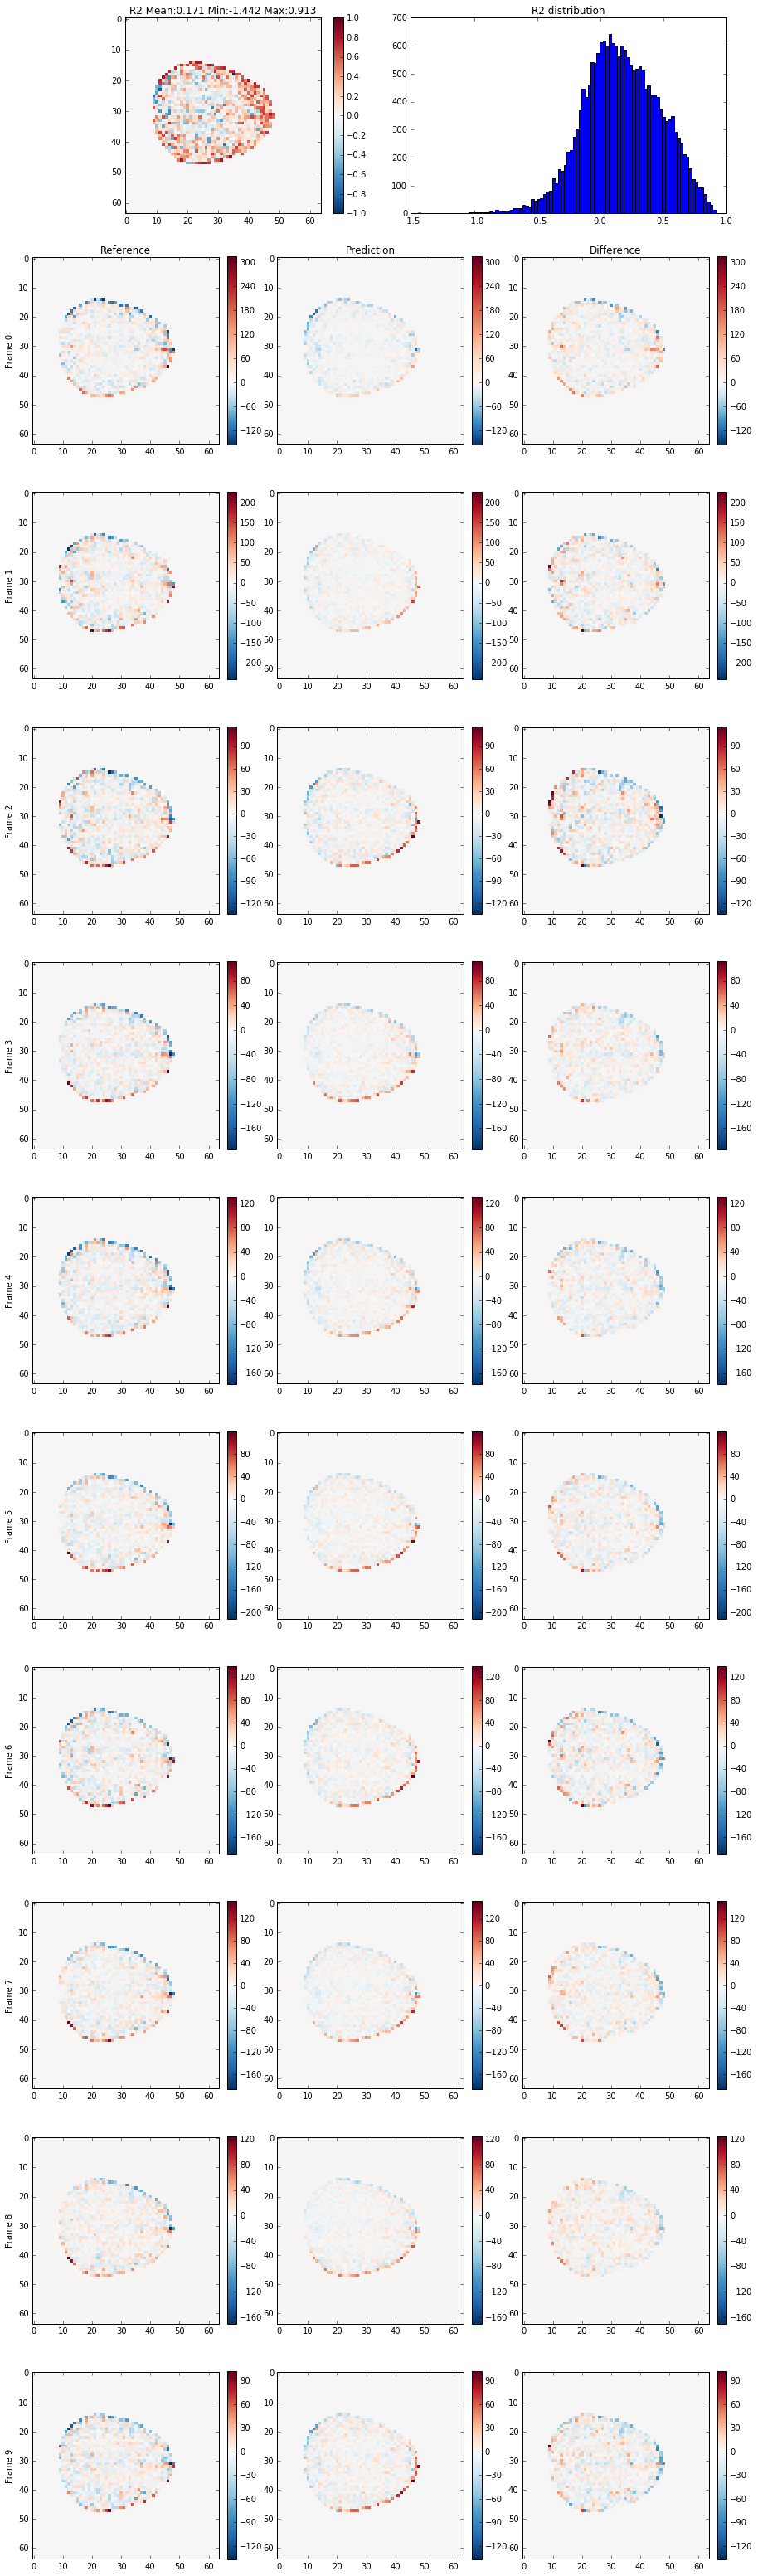

In [29]:
show_report(np.vstack(ref_vals),np.vstack(pred_vals),mask_b,frames=np.arange(0,10))
print fd[0:10]

In [30]:
model.layers[-1].get_weights()



[]